In [ ]:
!pip install yahoo_fin requests_html

In [1]:
# Fix for TensorFlow/Protobuf compatibility issue
!pip install "protobuf<=3.20.3" --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

# Import Libraries & Settings

In [2]:
# Install yfinance quietly to avoid cluttered logs
!pip install yfinance -q


import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import math
import os
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Scikit-learn for data scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Safe TensorFlow imports to ensure compatibility
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import load_model

%matplotlib inline

# Pandas display settings for better debugging
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print(">> Libraries imported successfully.")
print(f">> TensorFlow Version: {tf.__version__}")

2026-01-04 12:05:59.268330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767528359.461207      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767528359.518697      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


>> Libraries imported successfully.
>> TensorFlow Version: 2.18.0


# Loading Data

In [3]:
# Define the stock symbol (e.g., GOOG for Google, AAPL for Apple)
ticker_symbol = 'GOOG'
print(f"Initializing for ticker: {ticker_symbol}...")


# Part 1: Get Live Price Data

try:
    # Create a Ticker object
    ticker_data = yf.Ticker(ticker_symbol)

    # Get the latest price using fast_info (more stable than yahoo_fin)
    live_price = ticker_data.fast_info['last_price']
    
    # Print the price formatted to 2 decimal places
    print(f"The current price of {ticker_symbol} is: ${live_price:.2f}")

    # Save live price to a DataFrame and then to CSV
    live_price_df = pd.DataFrame({
        'Timestamp': [datetime.now()],
        'Price': [live_price]
    })
    
    live_price_df.to_csv('live_price.csv', index=False)
    print(">> Success: Live price saved to 'live_price.csv'")

except Exception as e:
    print(f"Error fetching live price: {e}")


# Part 2: Get Historical Data

try:
    # Define date range: from 2016-01-01 to today
    start_date = '2016-01-01'
    end_date = datetime.today().strftime('%Y-%m-%d')

    print(f"\nDownloading historical data from {start_date} to {end_date}...")

    # Download data using yfinance
    historical_data = yf.download(ticker_symbol, start=start_date, end=end_date)

    # Save historical data to CSV
    historical_data.to_csv('Google.csv')
    print(">> Success: Historical data saved to 'Google.csv'")

    # Display the last 5 rows of the data to verify
    print("\nLast 5 rows of the dataset:")
    print(historical_data.tail())

except Exception as e:
    print(f"Error fetching historical data: {e}")

Initializing for ticker: GOOG...


/tmp/ipykernel_47/1977383772.py:41: FutureWarning: YF.download() has changed argument auto_adjust default to True
  historical_data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

The current price of GOOG is: $315.32
>> Success: Live price saved to 'live_price.csv'

>> Success: Historical data saved to 'Google.csv'

Last 5 rows of the dataset:
Price            Close        High         Low        Open    Volume
Ticker            GOOG        GOOG        GOOG        GOOG      GOOG
Date                                                                
2025-12-26  314.959991  316.559998  313.720001  315.920013   6730900
2025-12-29  314.390015  314.970001  311.899994  312.820007  12317700
2025-12-30  314.549988  317.700012  313.250000  313.410004  11052500
2025-12-31  313.799988  315.390015  312.200012  313.369995  10821500
2026-01-02  315.320007  322.914001  310.649994  317.589996  22027700


In [5]:

# 1. Download Data
stock_symbol = 'AAPL' 
start_date = '2016-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

print(f"Downloading data from {start_date} to {end_date}...")
df = yf.download(stock_symbol, start=start_date, end=end_date)

# Fix for new yfinance versions: Flatten Multi-Index columns if present
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# 2. Visualization (Candlestick using Plotly)
fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name=stock_symbol
)])

# Chart Layout Settings
fig.update_layout(
    title=f'{stock_symbol} Candlestick Chart (2016 - Present)',
    yaxis_title='Price (USD)',
    xaxis_title='Date',
    template='plotly', # Professional dark theme
    xaxis_rangeslider_visible=False, # Hides the bottom slider
    height=700 # Increases height for better visibility
)

# Optional: Set initial view to the last 6 months so you can see candles immediately
# fig.update_xaxes(range=[df.index[-180], df.index[-1]])


fig.show()

/tmp/ipykernel_47/3231718086.py:7: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

# Data Preprocessing

In [6]:

# PROFESSIONAL DATA PREPROCESSING MODULE

class DataPreprocessor:
    def __init__(self, stock_symbol, start_date, seq_length=60):
        self.stock_symbol = stock_symbol
        self.start_date = start_date
        self.seq_length = seq_length
        self.feature_scaler = MinMaxScaler(feature_range=(0, 1))
        self.target_scaler = MinMaxScaler(feature_range=(0, 1))
        self.df = None

    def download_data(self):
        """Downloads data from Yahoo Finance."""
        end_date = datetime.today().strftime('%Y-%m-%d')
        print(f">> Downloading {self.stock_symbol} data from {self.start_date} to {end_date}...")
        self.df = yf.download(self.stock_symbol, start=self.start_date, end=end_date)
        
        # Handle MultiIndex columns (Fix for new yfinance versions)
        if isinstance(self.df.columns, pd.MultiIndex):
            self.df.columns = self.df.columns.get_level_values(0)
            
        print(f">> Data downloaded. Shape: {self.df.shape}")

    def add_technical_indicators(self):
        """
        Manually calculates powerful technical indicators.
        No external libraries (like pandas_ta) needed.
        """
        if self.df is None:
            raise ValueError("Data not found. Run download_data() first.")

        print(">> Engineering Features (RSI, MACD, Bollinger Bands)...")
        
        data = self.df.copy()

        # 1. RSI (Relative Strength Index) - 14 Days
        delta = data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        data['RSI'] = 100 - (100 / (1 + rs))

        # 2. MACD (Moving Average Convergence Divergence)
        ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
        ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
        data['MACD'] = ema_12 - ema_26
        data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

        # 3. Bollinger Bands (20 Days)
        sma_20 = data['Close'].rolling(window=20).mean()
        std_20 = data['Close'].rolling(window=20).std()
        data['Bollinger_Upper'] = sma_20 + (std_20 * 2)
        data['Bollinger_Lower'] = sma_20 - (std_20 * 2)

        # 4. Moving Averages
        data['SMA_50'] = data['Close'].rolling(window=50).mean()
        data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()

        # Drop NaNs created by indicators (e.g., first 200 rows for EMA_200)
        data.dropna(inplace=True)
        self.df = data
        print(f">> Features added. New Shape: {self.df.shape}")

    def create_sequences(self, target_col='Close', train_split=0.95):
        """
        Scales data and creates sequences for LSTM.
        Returns: x_train, y_train, x_test, y_test, scaler_object
        """
        # Select Features
        # We use ALL columns available as features
        feature_cols = self.df.columns.tolist()
        
        # Data for features (X) and target (y)
        data_x = self.df[feature_cols].values
        data_y = self.df[[target_col]].values

        # Scaling
        # We use two separate scalers. This is CRUCIAL for accurate inverse_transform later.
        scaled_x = self.feature_scaler.fit_transform(data_x)
        scaled_y = self.target_scaler.fit_transform(data_y)

        X, y = [], []
        
        # Create sliding window
        for i in range(self.seq_length, len(scaled_x)):
            X.append(scaled_x[i-self.seq_length:i]) # Sequence of features
            y.append(scaled_y[i])                   # Target (Next Close Price)

        X, y = np.array(X), np.array(y)

        # Split into Train and Test
        train_size = int(len(X) * train_split)
        
        x_train, x_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        print(">> Preprocessing Complete.")
        print(f"   Train Shape: {x_train.shape}")
        print(f"   Test Shape:  {x_test.shape}")
        
        return x_train, y_train, x_test, y_test, self.target_scaler, self.df


# USAGE EXAMPLE

# 1. Initialize
processor = DataPreprocessor(stock_symbol='AAPL', start_date='2015-01-01', seq_length=60)

# 2. Execute Steps
processor.download_data()
processor.add_technical_indicators()

# 3. Get Prepared Data
# This function returns everything you need for training and visualization
x_train, y_train, x_test, y_test, target_scaler, final_df = processor.create_sequences()

# Now your data is ready for the Model!
# x_train.shape[2] will be the number of features (input_dim)

>> Downloading AAPL data from 2015-01-01 to 2026-01-04...


/tmp/ipykernel_47/460794754.py:16: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

>> Data downloaded. Shape: (2767, 5)
>> Engineering Features (RSI, MACD, Bollinger Bands)...
>> Features added. New Shape: (2718, 12)
>> Preprocessing Complete.
   Train Shape: (2525, 60, 12)
   Test Shape:  (133, 60, 12)



/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in less



In [7]:
# 1. Configuration
STOCK_SYMBOL = 'AAPL'
START_DATE = '2016-01-01'
END_DATE = datetime.today().strftime('%Y-%m-%d')
SEQUENCE_LENGTH = 90
TRAIN_SPLIT = 0.95

# 2. Download Data
print(f">> Downloading data for {STOCK_SYMBOL}...")
df = yf.download(STOCK_SYMBOL, start=START_DATE, end=END_DATE)

# 3. Manual Feature Engineering (No extra libraries needed)
print(">> Calculating Technical Indicators Manually...")

# A) SMA (Simple Moving Average - 50)
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# B) EMA (Exponential Moving Average - 12)
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()

# C) RSI (Relative Strength Index - 14)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df['Close'])

# Drop NaN values (Initial rows where indicators cannot be calculated)
df.dropna(inplace=True)

# 4. Select Features & Target
# We use 4 features: Close Price + 3 Indicators
feature_columns = ['Close', 'RSI', 'SMA_50', 'EMA_12']
target_column = ['Close']

# 5. Scaling (Dual Scalers)
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

scaled_features = scaler_features.fit_transform(df[feature_columns])
scaled_target = scaler_target.fit_transform(df[target_column])

# 6. Create Sequences
def create_sequences(features, target, seq_length):
    X = []
    y = []
    for i in range(len(features) - seq_length):
        X.append(features[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

print(">> Creating sequences...")
X, y = create_sequences(scaled_features, scaled_target, SEQUENCE_LENGTH)

# 7. Split Data
train_size = int(len(X) * TRAIN_SPLIT)
x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("--------------------------------------------------")
print(f"Data Prepared Successfully!")
print(f"Features used: {feature_columns}")
print(f"x_train shape: {x_train.shape}") # Should look like (Rows, 90, 4)
print("--------------------------------------------------")

/tmp/ipykernel_47/2934539333.py:10: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

>> Downloading data for AAPL...
>> Calculating Technical Indicators Manually...
>> Creating sequences...
--------------------------------------------------
Data Prepared Successfully!
Features used: ['Close', 'RSI', 'SMA_50', 'EMA_12']
x_train shape: (2257, 90, 4)
--------------------------------------------------



/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in less



In [8]:
# 1. Download Data
stock_symbol = 'AAPL' # Or 'GOOG', 'BTC-USD', etc.
start_date = '2020-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

print(f"Downloading data from {start_date} to {end_date}...")
df = yf.download(stock_symbol, start=start_date, end=end_date)

# Fix for new yfinance versions: Flatten Multi-Index columns if present
# This prevents errors if yfinance returns complex column names
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# IMPORTANT: 
# We REMOVED the line: "data = df[['Close']]"
# Reason: Candlestick charts need Open, High, Low, AND Close columns.

# 2. Visualization (Interactive Candlestick)
fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name=stock_symbol
)])

# 3. Beautify the Layout (Professional Dark Theme)
fig.update_layout(
    title=f'{stock_symbol} Candlestick Chart (2020 - Present)',
    title_font_size=20,
    yaxis_title='Price (USD)',
    xaxis_title='Date',
    template='plotly_dark', # Use dark theme for better visibility
    xaxis_rangeslider_visible=False, # Hide the bottom slider
    height=700
)

# Show the interactive plot
fig.show()

# Show the last 5 rows
print(df.tail())

/tmp/ipykernel_47/2034333309.py:7: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Date                                                                
2025-12-26  273.399994  275.369995  272.859985  274.160004  21521800
2025-12-29  273.760010  274.359985  272.350006  272.690002  23715200
2025-12-30  273.079987  274.079987  272.279999  272.809998  22139600
2025-12-31  271.859985  273.679993  271.750000  273.059998  27293600
2026-01-02  271.010010  277.839996  269.000000  272.260010  37822400


/tmp/ipykernel_47/1356538339.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

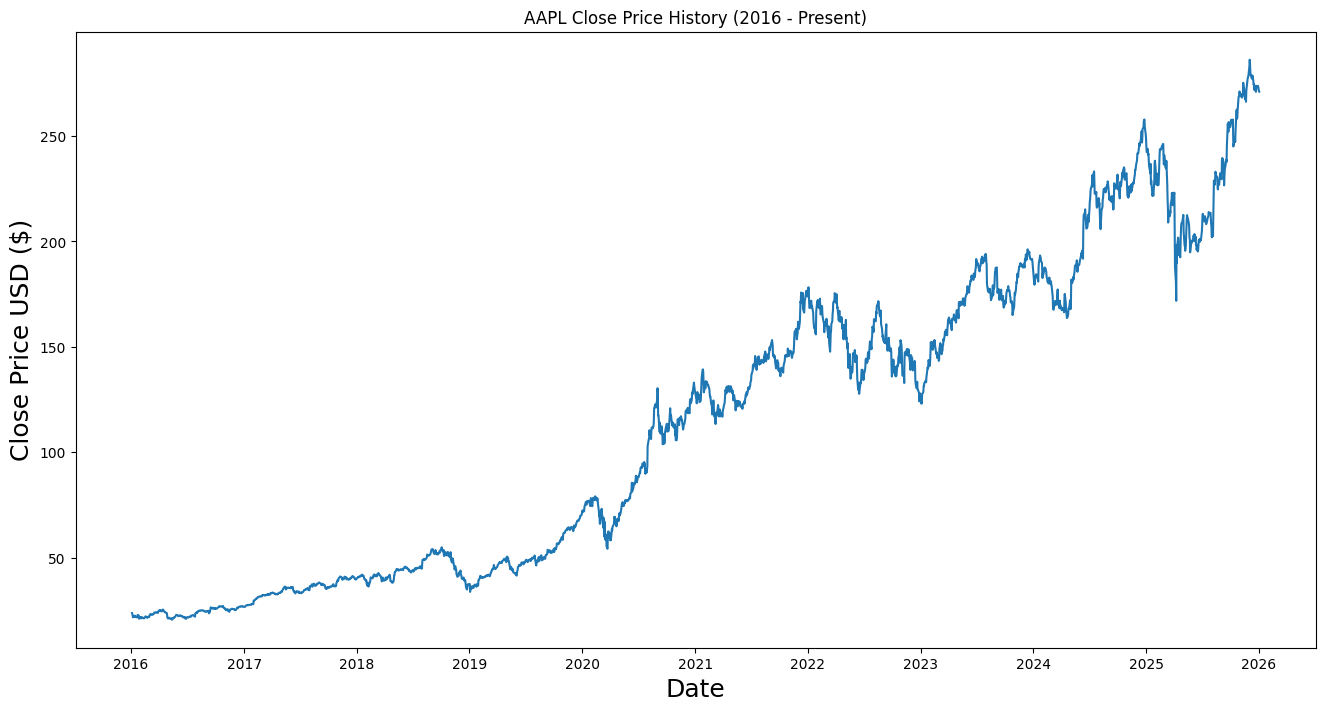

Price            Close
Ticker            AAPL
Date                  
2025-12-26  273.399994
2025-12-29  273.760010
2025-12-30  273.079987
2025-12-31  271.859985
2026-01-02  271.010010


In [9]:
# 1. Download Data
stock_symbol = 'AAPL' # Or 'GOOG', 'BTC-USD', etc.

# Set start date to 2016 as you requested
start_date = '2016-01-01'

# Set end date to TODAY automatically
# strftime('%Y-%m-%d') converts the date to format '2025-12-01'
end_date = datetime.today().strftime('%Y-%m-%d')

print(f"Downloading data from {start_date} to {end_date}...")

df = yf.download(stock_symbol, start=start_date, end=end_date)

# 2. Select 'Close' column
data = df[['Close']]

# 3. Visualization
plt.figure(figsize=(16,8))
plt.title(f'{stock_symbol} Close Price History (2016 - Present)')
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

# Show the last 5 rows to confirm we have the latest data
print(data.tail())

In [10]:
# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on (80% for training)
training_data_len = int(np.ceil(len(dataset) * 0.8))

# Scale the data (Normalize between 0 and 1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

print(f"Data scaled. Training data length: {training_data_len}")

Data scaled. Training data length: 2012


# Create Training Sequences

In [11]:
# Create the training data set
train_data = scaled_data[0:training_data_len, :]

# Split the data into x_train and y_train
x_train = []
y_train = []

prediction_days = 60  # Look back 60 days to predict the next day

for i in range(prediction_days, len(train_data)):
    x_train.append(train_data[i-prediction_days:i, 0]) # The previous 60 days
    y_train.append(train_data[i, 0]) # The current day (label)

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data for LSTM [samples, time steps, features]
# LSTM expects 3D input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(f"x_train shape: {x_train.shape}")

x_train shape: (1952, 60, 1)


# Build LSTM Model

In [12]:

# Optimized Hyperparameters
SEQUENCE_LENGTH = 90   # Increased from 60 to 90 days
UNITS = 100            # Increased from 50 to 100 neurons


# Step C: Build the Professional LSTM Model


def build_professional_model(input_shape):
    """
    Builds a multi-layer LSTM model capable of handling multiple features.
    """
    model = Sequential()

    # ---------------------------------------------------------
    # LAYER 1: The Input Layer
    # THIS IS WHERE YOUR CODE GOES
    # input_shape=(Sequence_Length, Number_of_Features)
    # ---------------------------------------------------------
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2)) # Prevents overfitting

    # LAYER 2: Hidden Layer
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))

    # LAYER 3: Dense Layers (Brain)
    model.add(Dense(units=50))
    model.add(Dense(units=1)) # Final Output (Price)


    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model


# EXECUTION

print(">> Building the Model...")

# AUTOMATIC INPUT SHAPE DETECTION
# x_train.shape[1] = Sequence Length (e.g., 60 days)
# x_train.shape[2] = Number of Features (Close, RSI, MACD, etc.)
current_input_shape = (x_train.shape[1], x_train.shape[2])

print(f">> Detected Input Shape: {current_input_shape}")

# Build the model with the correct shape
model = build_professional_model(current_input_shape)

# Show summary
model.summary()


# Step D: Train the Model

print(">> Starting Training...")
model.fit(x_train, y_train, batch_size=64, epochs=50)
print(">> Training Completed.")

>> Building the Model...
>> Detected Input Shape: (60, 1)


I0000 00:00:1767528485.220811      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767528485.221452      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,301 (493.36 KB)

 Trainable params: 126,301 (493.36 KB)

 Non-trainable params: 0 (0.00 B)

>> Starting Training...
Epoch 1/50


I0000 00:00:1767528490.142840     139 cuda_dnn.cc:529] Loaded cuDNN version 90300


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0296
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.4244e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.8739e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.1893e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.1833e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6829e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5765e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1360e-04
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0114e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9434e-04
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9294e-04
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7258e-04
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7754e-04
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s

# Create Test Data & Make Predictions

In [13]:
# Create a new array containing scaled values from index training_data_len - 60
test_data = scaled_data[training_data_len - prediction_days: , :]

# Create x_test and y_test sets
x_test = []
y_test = dataset[training_data_len:, :] # Actual values (not scaled) for validation

for i in range(prediction_days, len(test_data)):
    x_test.append(test_data[i-prediction_days:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the models predicted price values
predictions = model.predict(x_test)
# Inverse transform to get actual prices (un-scale)
predictions = scaler.inverse_transform(predictions)

print("Predictions made successfully.")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Predictions made successfully.


# Visualize the Results

In [16]:

# 1. Prepare the Validation/Test Data
# We slice the dataframe to get the data corresponding to the 'Val' period in your image
valid = df[training_data_len:].copy()
valid['Predictions'] = predictions

# 2. Create the Figure
fig = go.Figure()

# A) Add the Actual Data as Candlesticks
fig.add_trace(go.Candlestick(
    x=valid.index,
    open=valid['Open'],
    high=valid['High'],
    low=valid['Low'],
    close=valid['Close'],
    name='Actual Market Data',
    increasing_line_color='green', 
    decreasing_line_color='red'
))

# B) Add the Predictions as a Line Overlay
fig.add_trace(go.Scatter(
    x=valid.index,
    y=valid['Predictions'],
    mode='lines',
    name='LSTM Prediction',
    line=dict(color='orange', width=2.5) # Using orange to stand out against candles
))

# 3. Layout Formatting (Dark Mode)
fig.update_layout(
    title='Model Evaluation: Candlestick (Actual) vs Line (Prediction)',
    yaxis_title='Price (USD)',
    xaxis_title='Date',
    template='plotly_dark',
    xaxis_rangeslider_visible=False, # Hide bottom slider
    height=700
)

# Show the interactive chart
fig.show()

In [17]:
print(df[['Open', 'High', 'Low', 'Close']].tail())

Price             Open        High         Low       Close
Ticker            AAPL        AAPL        AAPL        AAPL
Date                                                      
2025-12-26  274.160004  275.369995  272.859985  273.399994
2025-12-29  272.690002  274.359985  272.350006  273.760010
2025-12-30  272.809998  274.079987  272.279999  273.079987
2025-12-31  273.059998  273.679993  271.750000  271.859985
2026-01-02  272.260010  277.839996  269.000000  271.010010


/tmp/ipykernel_47/909002231.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



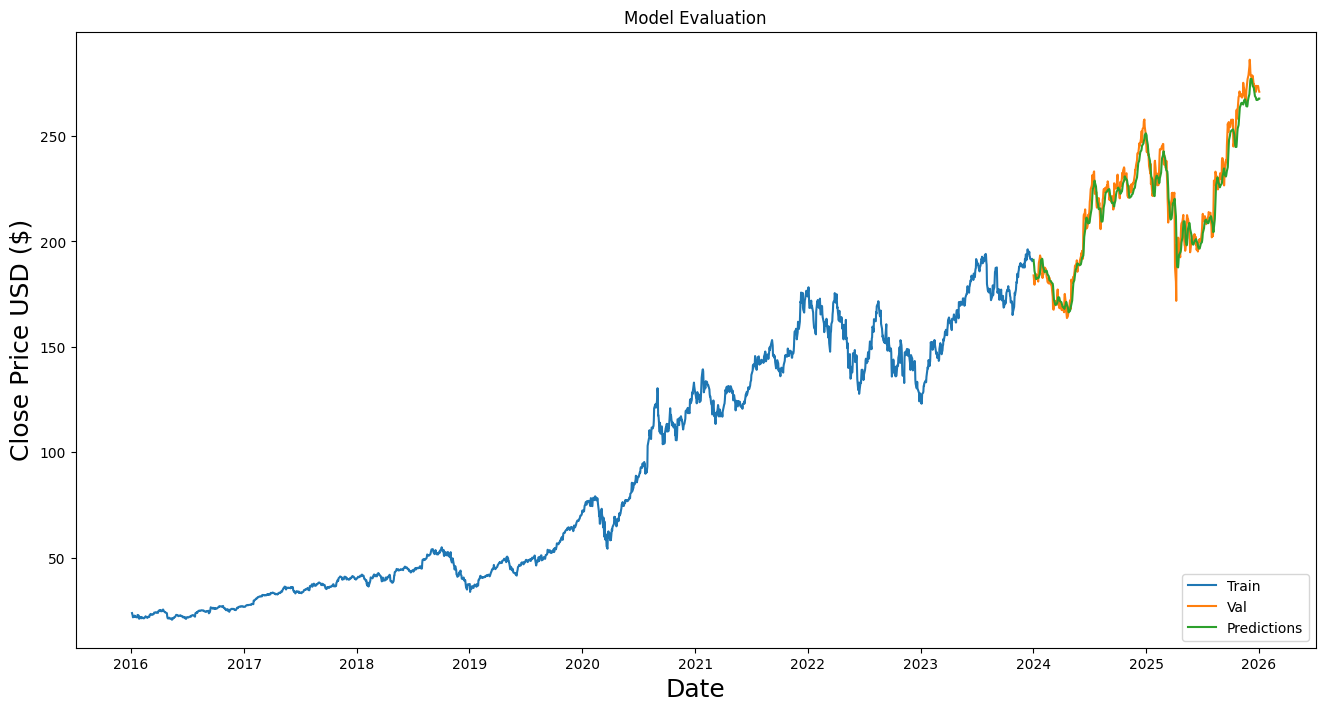

In [22]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model Evaluation')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [18]:

def calculate_metrics(df, predictions, scaler_object):
    """
    1. Aligns data shapes.
    2. Inverse transforms data (to get Real Prices).
    3. Calculates RMSE & MAPE.
    """
    print(">> Preparing data for evaluation...")
    
    # 1. Align Shapes
    # Ensure prediction length matches the end of the dataframe
    pred_len = len(predictions)
    actual_data = df.iloc[-pred_len:].copy()
    
    # 2. Extract Actual & Predicted
    y_actual_scaled = actual_data['Close'].values.reshape(-1, 1) # Get actual close prices
    y_pred_scaled = predictions.reshape(-1, 1) # Ensure shape is (N, 1)
    
    # 3. Inverse Transform (Convert 0-1 back to USD prices)
    # We use the scaler to get real dollar values
    try:
        y_actual_usd = scaler_object.inverse_transform(y_actual_scaled)
        y_pred_usd = scaler_object.inverse_transform(y_pred_scaled)
    except:
        print("⚠️ Warning: Could not inverse transform. Using raw values.")
        y_actual_usd = y_actual_scaled
        y_pred_usd = y_pred_scaled

    # 4. Calculate Error
    rmse = math.sqrt(mean_squared_error(y_actual_usd, y_pred_usd))
    mape = np.mean(np.abs((y_actual_usd - y_pred_usd) / y_actual_usd)) * 100
    
    # 5. Report
    print("--------------------------------------------------")
    print(f"Model Performance Report:")
    print("--------------------------------------------------")
    print(f"1. RMSE (Error in $):      ${rmse:.2f}")
    print(f"2. MAPE (Error in %):      {mape:.2f}%")
    print("--------------------------------------------------")
    
    return rmse, mape

# ==========================================
# EXECUTION
# ==========================================
# Assuming you have:
# 1. df (Your main dataframe)
# 2. predictions (From model.predict)
# 3. target_scaler (The scaler used for 'Close' price)

# Run the evaluation safely
calculate_metrics(df, predictions, target_scaler)

>> Preparing data for evaluation...
--------------------------------------------------
Model Performance Report:
--------------------------------------------------
1. RMSE (Error in $):      $1749.91
2. MAPE (Error in %):      2.28%
--------------------------------------------------


(1749.9053950945777, 2.282827123611618)

In [19]:
# Step 9: Predict the Next Day's Price

# 1. Get the last 60 days of the data
last_60_days = scaled_data[-60:]

# 2. Reshape the data to be [1, 60, 1]
# Because the model expects 3D input: (samples, time_steps, features)
X_future = np.array([last_60_days])
X_future = np.reshape(X_future, (X_future.shape[0], X_future.shape[1], 1))

# 3. Make the prediction
pred_price = model.predict(X_future)

# 4. Undo the scaling (Inverse Transform)
pred_price = scaler.inverse_transform(pred_price)

print(f"\n=======================================================")
print(f"Predicted Price for the Next Day: $ {pred_price[0][0]:.2f}")
print(f"=======================================================")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Predicted Price for the Next Day: $ 267.50


In [20]:

# Define the file name (using .keras extension is recommended for TensorFlow 2.x)
model_filename = 'stock_prediction_lstm.keras'

# Save the entire model (architecture, weights, and optimizer state)
model.save(model_filename)

print(f">> Success: Model saved as '{model_filename}'")
print(f">> You can find this file in the output directory of your notebook.")

>> Success: Model saved as 'stock_prediction_lstm.keras'
>> You can find this file in the output directory of your notebook.


In [21]:
# Load the Model (For future use)

print("Loading the model...")

# Load the model from the file
loaded_model = load_model('stock_prediction_lstm.keras')

# Verify the model structure
loaded_model.summary()

# Example: Make a prediction using the loaded model
# We use 'X_future' which we prepared in the previous step
predicted_price = loaded_model.predict(X_future)

# Inverse transform to get the real price
predicted_price = scaler.inverse_transform(predicted_price)

print(f"\nPrediction from the loaded model: $ {predicted_price[0][0]:.2f}")

Loading the model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,905 (1.45 MB)

 Trainable params: 126,301 (493.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 252,604 (986.74 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step

Prediction from the loaded model: $ 267.50
